In [25]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import *
%matplotlib inline

## Part 1: Importing data

In [2]:
#import data into separate columns
input = '../data/data.dat'
distance, error, velocity = np.loadtxt(input, usecols = (0,1,2), unpack = True, skiprows=7, delimiter='\t')

velocity = velocity/1000

#velocity now in m/s

## Part 2: Plotting data w/ error on y-axis

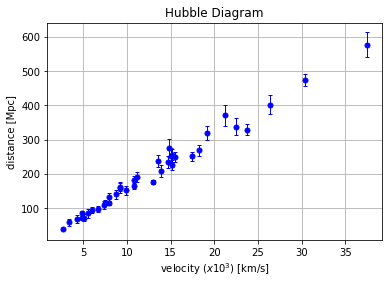

In [29]:
#initial plot
%matplotlib inline
plt.title('Hubble Diagram')
plt.ylabel('distance [Mpc]')
plt.xlabel('velocity ($x10^{3}$) [km/s]')
plt.grid(True)
plt.errorbar(velocity, distance, yerr=error, fmt='bo', capsize=2, elinewidth=1, markersize=5)
plt.savefig('hubblediagram.pdf', dpi=1000)
plt.show()

## Part 3: Unweighted fit using polyfit

In [4]:
fit = np.polyfit(velocity, distance, deg=1)
fit = fit[::-1] #reverse the array

#check
print(fit)

[  5.16280981  15.35262538]


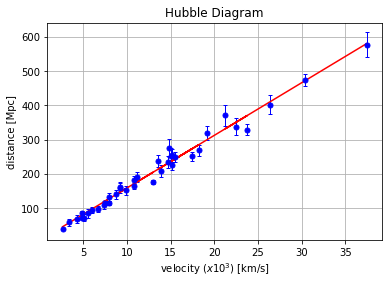

In [30]:
#plot data with polyfit line

bestfit = fit[0]+fit[1]*velocity

%matplotlib inline
plt.errorbar(velocity, distance, yerr=error, fmt='bo', capsize=2, elinewidth=1, markersize=5)
plt.title('Hubble Diagram')
plt.ylabel('distance [Mpc]')
plt.xlabel('velocity ($x10^{3}$) [km/s]')
plt.grid(True)
plt.plot(velocity, bestfit, 'r-')
plt.savefig('hubblediagram_fitted.pdf', dpi=1000)
plt.show()

## Part 3b: Histogram of residuas/error bars

[ -7.13599901   0.82068841  -1.89633583  -7.65010859 -11.32062988
   4.56875641  -5.40599783  -3.64878912 -11.12740855  -9.11587446
 -12.24593556  -4.28072113   6.02406444   0.7570402   -4.51603712
  11.64424891  16.90167225  -6.6477545  -28.12648581  11.18133543
  15.37157068  -9.84744666 -11.19892879   3.53015083  23.84693982
   4.37774832 -21.24492991  16.71591788  16.48311627 -16.01748595
  42.47545769  20.70822    -40.71605223 -13.08919183  38.75320036
  -7.91552977   3.44328563  -4.455771  ]


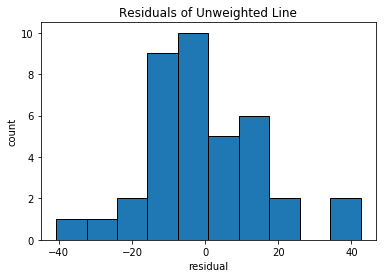

In [6]:
residuals = distance-bestfit

#glance at residuals to check against histogram
print(residuals)

%matplotlib inline
plt.hist(residuals, ec='black')
plt.title('Residuals of Unweighted Line')
plt.ylabel('count')
plt.xlabel('residual')
plt.show()

#plot histogram

In [7]:
#is this distribution gaussian?
#f(x,mu,sigma) = (1/(sigma*sqrt(2pi)))*e^((x-mu)^2/(2*sigma^2))
#mu = mean; sigma = stdev

In [8]:
sigma = np.std(residuals)
mu = np.mean(residuals)
x = np.arange(-50,50,.5) #200 points

In [9]:
def Gaussian(x, mu, sigma):
    """models a normal Gaussian distribution with mean mu,
    standard deviation sigma, and domain x"""
    
    f1 = (1/(sigma*np.sqrt(2*np.pi)))
    f2 = np.power(np.e, -np.power(x-mu, 2)/(2*np.power(sigma, 2)))
    
    values = f1*f2
    
    return values

In [10]:
gaussianFit = 400*Gaussian(x, mu, sigma)

#ensure values make sense
#print(gaussianFit)

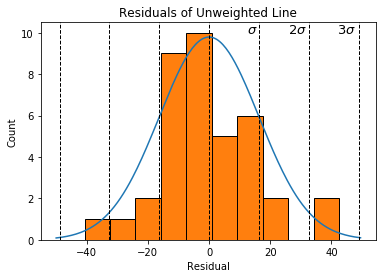

In [11]:
dottedlines = [-3*sigma, -2*sigma, -sigma, 0, sigma, 2*sigma, 3*sigma]

%matplotlib inline
plt.plot(x, gaussianFit)
plt.hist(residuals, ec='black')
plt.title('Residuals of Unweighted Line')
plt.ylabel('Count')
plt.xlabel('Residual')
plt.text(16, 10, r'$\sigma$', ha='right', size=13)
plt.text(32, 10, r'$2\sigma$', ha='right', size=13)
plt.text(48, 10, r'$3\sigma$', ha='right', size=13)
for x in dottedlines:
    plt.axvline(x, color='k', linestyle='--', linewidth=1)
plt.savefig('gaussian_residuals.pdf')
plt.show()

Histogram seems fairly Guassian

## Part 4: Unweighted normal equation

In [12]:
#create X matrix full of ones
n = len(velocity)
X = np.array([np.ones(n), np.ones(n)]).T

#leave first column full of ones
#populate second column with velocity values
for i in range(n):
    X[i,1] = velocity[i]
    
#visually check the matrix
#print(X)

In [13]:
#create y matrix

y = np.array(np.ones(n)).reshape(-1,1)
for i in range(n):
    y[i,0] = distance[i]
    
#visually check the matrix
#print(y)

In [27]:
beta = np.linalg.solve(X.T.dot(X), X.T.dot(y))

print('coefficients from unweighted normal equation:')
print(beta, 2*'\n')

print('coefficients from numpy.polyfit:')
print(fit, 2*'\n')

print('same answer!')

coefficients from unweighted normal equation:
[[  5.16280981]
 [ 15.35262538]] 


coefficients from numpy.polyfit:
[  5.16280981  15.35262538] 


same answer!


## Part 5: Use polyfit w/ weighting, output covariance matrix

In [15]:
#w = 1/sigma
best, cov = np.polyfit(velocity, distance, 1, w=1/error, cov=True)

In [28]:
print('polyfit with error weight:')
for i in range(len(best)):
    print('a[{}] = {} +/- {}'.format(i, best[i], np.sqrt(cov[len(best)-i-2][len(best)-i-2])))

print('\npolyfit covariance matrix =')
print(cov)

print(DataFrame(cov))

polyfit with error weight:
a[0] = 15.307588858770766 +/- 0.3323075439391008
a[1] = -0.6427312185483293 +/- 2.846791473297645

polyfit covariance matrix =
[[ 0.1104283  -0.76154614]
 [-0.76154614  8.10422169]]
          0         1
0  0.110428 -0.761546
1 -0.761546  8.104222


## Part 6: Express age of the universe

In [17]:
#diagonal of covariance matrix gives errors

def age_coversion(h):
    #from Mpc/m/s
    #multiply by m/Mpc
    km_to_mpc = 3.0856776e19
    s_in_year = 3.15576e7
    
    age = h*(1/1000)*km_to_mpc*(1/s_in_year)*(1/1e9)
    
    return age

In [18]:
error_cov = np.sqrt(cov[0][0])

print('The age of the universe is {} +/- {} billion years.'.format(age_coversion(best[0]), age_coversion(error_cov)))

The age of the universe is 14.96764140857306 +/- 0.32492773361849414 billion years.


## Part 8*: Perturbing data

In [19]:
def perturbed(err):
    touch = np.random.normal(0, err)
    return touch

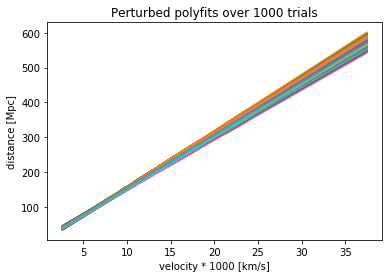

In [32]:
n = 1000 #trials

gradient = []

for i in range(n):
    perturbed_data = distance + perturbed(error)
    new_fit = np.polyfit(velocity, perturbed_data, 1, w=1/error)
    
    gradient.append(new_fit[0])
    plt.plot(velocity, velocity*new_fit[0] + new_fit[1])

plt.title('Perturbed polyfits over 1000 trials')
plt.ylabel('distance [Mpc]')
plt.xlabel('velocity * 1000 [km/s]')
plt.savefig('perturbed_polyfit.pdf', dpi=1000)
plt.show()

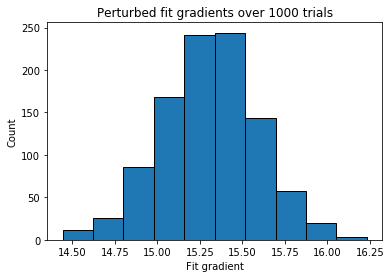

In [31]:
plt.hist(gradient, ec='black')
plt.title('Perturbed fit gradients over 1000 trials')
plt.ylabel('Count')
plt.xlabel('Fit gradient')
plt.savefig('perturbed_histogram.pdf', dpi=1000)
plt.show()